In [1]:
import stream_time_reversability as STR
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tstrippy
import datetime
import multiprocessing as mp
from astropy import units as u
from astropy.coordinates import SkyCoord
import h5py

In [2]:
integrationtime = 1/100
currenttime = 0 

In [3]:
MWparams = tstrippy.Parsers.pouliasis2017pii()
dtfactor = 1/100
staticgalaxy = ["pouliasis2017pii", MWparams]
G = MWparams[0]
M = 1e5
a = 5e-3
NP = int(1e2)
aplum = tstrippy.ergodic.convertHalfMassRadiusToPlummerRadius(a)
tau = STR.plummer_dynamical_time([G,M,a])

In [4]:
targetGC = "NGC6760"
initialkinematics = STR.pick_GC_get_kinematics(targetGC)

In [5]:
integrationparameters = STR.prepare_integration_arguments(currenttime=currenttime,
                                                          integrationtime=integrationtime,
                                                          tdyn=tau,
                                                          alpha=dtfactor)

print("nsteps", integrationparameters[-1])
integrationparameters = list(integrationparameters)


nsteps 2048


In [6]:
args = initialkinematics, staticgalaxy, integrationparameters
orbit, timestamps, comptime = STR.integrate_host_orbit_back(args)

integration time:  0:00:00.007868


In [7]:
integrationparameters

[0, np.float64(4.882812500000001e-06), 2048]

In [8]:
inithostperturber = [timestamps, *orbit, G, M, aplum ]
xp,yp,zp,vxp,vyp,vzp = tstrippy.ergodic.isotropicplummer(G,M,a,NP)
integrationparameters_stream = [timestamps[0],*integrationparameters[1:]]
initialkinematics_stream = [xp+orbit[0,0], yp+orbit[1,0], zp+orbit[2,0], vxp+orbit[3,0], vyp+orbit[4,0], vzp+orbit[5,0]]

In [9]:
streaminit = np.array([xp, yp, zp, vxp, vyp, vzp]).T + orbit[:,0]

In [10]:
args_stream = initialkinematics_stream, staticgalaxy, integrationparameters_stream, inithostperturber
stream,tesc, comptime = STR.leapfrogtofinalpositions_stream(args_stream)
print(f"Stream generation took {comptime} seconds")

Stream generation took 0.079394 seconds


In [11]:
# dx,dy,dz,dvx,dvy,dvz=(stream - orbit[:,0][:,np.newaxis]).T
dx,dy,dz,dvx,dvy,dvz=(stream - orbit[:,-1][:,np.newaxis])
dr = np.sqrt(dx**2 + dy**2 + dz**2)
phi0 = -G*M/(dr**2 + aplum**2)**(1/2)
T0 = (1/2) * (dvx**2 + dvy**2 + dvz**2) 
E0 = phi0 + T0

In [12]:
NSTEP = int(1e6)
NP = int(1e5)
Nc = 80e-9
Nmc = 50
NGC = 165
comptime=Nmc*NGC*NSTEP*NP*Nc * u.s
comptime.to(u.day) / 100

<Quantity 7.63888889 d>

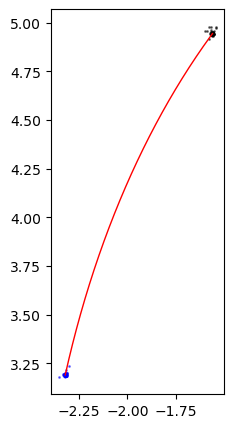

In [13]:
fig,axis= plt.subplots(1,1,figsize=(8.25-2,5))
axis.scatter(stream[0], stream[1], s=1, c='k', alpha=0.5)
axis.scatter(xp+orbit[0,0], yp+orbit[1,0], s=1, c='b', alpha=0.5, label='Stream particles')
axis.plot(orbit[0],orbit[1], c='r', lw=1, label='Host orbit')
axis.set_aspect('equal')

# Computation time

$$C(N_p, N_{\text{Steps}}) = A \cdot N_p^\alpha \cdot N_{\text{Steps}}^\beta $$

$$\log C = \log A + \alpha \log N_p + \beta \log N_{\text{Steps}} $$

$$\log C = \log A + \alpha \log N_p + \beta \log N_{\text{Steps}} $$


In [ ]:
import os 
targetGC = 'NGC6760'
integrationtime = 1  # in dynamical time units
NPs = np.logspace(1,3,3, dtype=int)  # number of particles for the stream
alphas = np.logspace(1,-2,3)
Nc = 80e-9 # mean time per single step 

In [69]:
path="./simulations/"
fnames=os.listdir("./simulations/")
NPs = [ ]
NSTEPS = []
comp = []
for i in range(1,len(fnames)):
    myfile=h5py.File(path+fnames[i], 'r')
    NSTEP = myfile['hostorbit'].shape[1]
    NP = myfile['streamfinal'].shape[1]
    comptimestream = myfile['comptimestream'][()]

    NPs.append(NP)
    NSTEPS.append(NSTEP)
    comp.append(comptimestream)

NPs = np.array(NPs)
NSTEPS = np.array(NSTEPS)
comp = np.array(comp)

In [84]:
np.mean(comp/NPs/NSTEPS)

np.float64(5.784719334676578e-06)

In [73]:
logNPS = np.log10(NPs)
logNSTEPS = np.log10(NSTEPS)
logcomp = np.log10(comp)

In [ ]:
A = np.vstack([np.ones_like(logNPS), logNPS, logNSTEPS]).T
# least squares fit
coeffs, residuals, rank, s = np.linalg.lstsq(A, logcomp, rcond=None)
logA, alpha, beta = coeffs

In [80]:
print(f"Fit: log C = {logA:.2f} + {alpha:.2f} log Np + {beta:.2f} log Nsteps")
print(f"Fit: C = 10^{logA:.2f} * Np^{alpha:.2f} * Nsteps^{beta:.2f}")

Fit: log C = -6.58 + 0.91 log Np + 1.28 log Nsteps
Fit: C = 10^-6.58 * Np^0.91 * Nsteps^1.28
